Import `qmprs` modules. For this demo, we will import the MPS instance.

In [1]:
import sys
sys.path.append("/home/ace07/Documents/GitHub/QMPRS")

In [2]:
from quick.circuit import QiskitCircuit
from quick.primitives import Ket

from qmprs.primitives import MPS
from qmprs.synthesis.mps_encoding import Sequential

/home/ace07/Documents/GitHub/QMPRS/.venv/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:57: UserWarning: Couldn't find `optuna`, `cmaes`, `baytune (btb)`, `chocolate`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/home/ace07/Documents/GitHub/QMPRS/.venv/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:76: UserWarning: Couldn't find `optuna`, `cmaes`, `baytune (btb)`, `chocolate`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


We will also import some basic modules for additional calculations and plotting.

In [3]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

### State Preparation using MPS Sequential

This notebook is dedicated to the demonstration of how `qmprs` can be used to create and manipulate matrix product states (MPS). In this notebook, we will go over the main functionalities of the `MPS` class and how it can be used at the high level to perform conventional MPS operations. This will set the intuition for how MPS can be used in gate-based quantum computing applications to perform state preparation or unitary synthesis.

At a high level, MPS [[3]] can be understood as an approximation of a tensor network where we represent the approximation as the product of a series of matrices. This is useful for quantum computing where we represent quantum states as 1D tensors, and quantum operators as matrices operating on 1D tensors. We can use MPS to approximate a given quantum state (and similarly a Matrix Product Operator (MPO) to approximate a quantum operator) given some measure $\chi$ called the bond dimension, whereby increasing the bond dimension we can reach higher fidelity approximations but at the cost of larger matrices. Conventionally, the cost of an MPS is as follows:

Circuit depth = $O(dN\chi^2)$

Where $d$ is the physical dimension of the state (which is equal to 2 for qubit-based representation), and $N$ is the number of qubits required to represent the state. At a glance, one can infer that given a constant bond dimension the cost of preparing the state scales linearly with the number of qubits, which is an exponential reduction compared to the usual exact encoding schema seen in [[1]] and [[2]].

[1]: https://arxiv.org/abs/1501.06911
[2]: https://arxiv.org/abs/quant-ph/0406176
[3]: https://arxiv.org/pdf/quant-ph/0608197

Below is an example of how we can create an MPS for some arbitrary quantum state. For ease in assessing the fidelity of the MPS, we will use images and compare the original image with the extracted image after constructing the MPS, and calculate the fidelity of the two using a simple inner product. For this example, we will use a Fashion MNIST datapoint.

In [4]:
# Load in the resized MNIST dataset
dataset = pd.read_csv('datasets/mnist-resized.csv')

# Convert the dataset to a numpy array
images = dataset.to_numpy()[:,1:].reshape(30018, 8, 8)

# Get the first image
test_image = images.reshape(30018, 8, 8)[0, :]

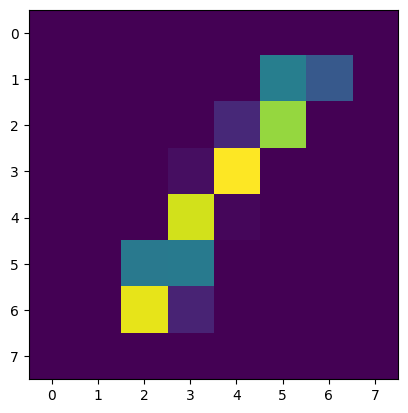

In [5]:
plt.imshow(test_image)

Next, we will convert this image to a quantum state using `quick.primitives.Ket`. `qmprs` is built with `quick` in mind, hence a great amount of the package utilizes the codebase built in `quick`.

In [36]:
# Create a `quick.primitives.Ket` instance
state = Ket(test_image.flatten())

# Create a `qmprs.mps.MPS` instance
mps = MPS(statevector=state, bond_dimension=64)

We can then reconstruct the state vector using `.to_statevector()` method.

/tmp/ipykernel_35406/3231258830.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  state = MPS.to_statevector(mps.mps).data.astype(float)


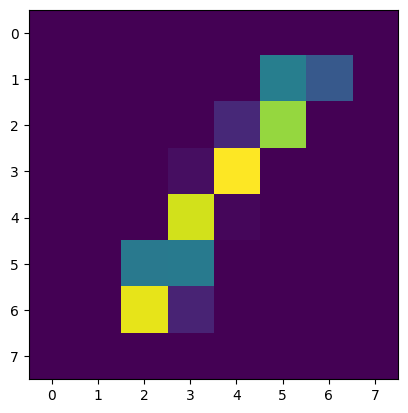

In [37]:
state = MPS.to_statevector(mps.mps).data.astype(float)

plt.imshow(state.reshape(8, 8))

MatrixProductState(tensors=6, indices=11, L=6, max_bond=5)

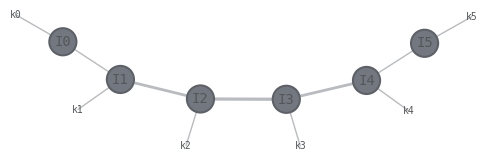

In [38]:
mps.draw()

mps.mps

To encode the MPS into a quantum circuit, we use the approach by Shiju Ran [[4]]. The approach iteratively generates unitary layers that disentangle the circuit to the product state $\ket{00 \cdots 0}$. We can exactly represent a dense vector $\ket{\psi}$ using a MPS with arbitrary bond dimension. In general, we can convert the tensors in the MPS into unitaries acting on $log_2(\chi) + 1$ qubits, and receive a layer like that. Additionally, given a MPS with bond dimension 2, we can receieve a single layer of two-qubit unitaries. However, to more effectively encode MPS to quantum circuits, we use the decomposition of MPS into multiple layers of two-qubit unitaries.

To encode the MPS using layers of two-qubit unitaries, we will use multiple layers to closely approximate the MPS. The pseudocode is as follows:

```
k = 0
psi_0 = psi

while k < K or |<psi_0|zero_state>| < target_fidelity:
    SVD compress psi_k to bond dimension 2
    convert psi_k_2 to a layer of two-qubit unitaries U_k
    apply U_k^adj to psi_k to update psi_k
    k = k + 1
end while
```

We generate a two-qubit layer, and apply its inverse to the MPS to update its definition so that we can generate the next layer. We add the layers to a list of layers. Once the MPS is sufficiently close to the zero state or we run out of layers, we have the following:

$\hat{U_k^\dagger} \cdots \hat{U_1^\dagger} \ket{\psi} = \ket{00 \cdots 0}$

Where $U_1, \cdots, U_k$ are the layers. Given the layers are unitary, we have:

$\ket{\psi} = U_1 \cdots U_k \ket{00 \cdots 0}$

Where $U_k$ is the first layer, and $U_1$ is the last layer applied to the circuit.

[4]: https://arxiv.org/abs/1908.07958

In [15]:
sequential_encoder = Sequential(QiskitCircuit) 

In [16]:
circuit = sequential_encoder.prepare_mps(mps, num_layers=32)

Convert datatype to float for plotting purposes.

In [17]:
statevector = circuit.get_statevector().astype(float)

/tmp/ipykernel_35406/3743751294.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  statevector = circuit.get_statevector().astype(float)


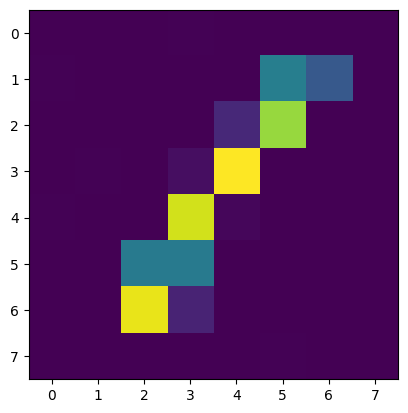

In [18]:
plt.imshow(statevector.reshape(8, 8))

In [21]:
np.dot(statevector.conj().T, state)

array([0.99999256])

In [20]:
circuit.get_depth()

291

Shiju Ran's approach is a great approximation especially given its analytical decomposition. However, the fidelity improvement is very small as we increase the number of layers. This causes fidelity loss issues as we increase the size of the systems we want to encode, and such puts the approach at a disadvantage. Hence, we use optimizations proposed first by [[5]] by Rudolph et al., where we utilize environment tensor updates to improve the quality of the unitary blocks without changing the circuit depth. This mitigates the fidelity loss significantly and allows for a proper compilation with desired fidelity if feasible.

Environment tensor optimization requires a tensor network representation of the circuit, with the adjoint of target MPS being contracted with the output legs of the circuit. This when fully contracted provides us with the inner-product or fidelity of the encoding. To perform the optimization, we iterate over the two-qubit unitary tensors, remove them to leave 4 free legs, and contract the tensor network to receive a 2x2x2x2 tensor. This is denoted by $F_m$ and is called the environment tensor. This tensor is the optimal tensor for maximizing the fidelity, but it is not guaranteed to be unitary. To approximate it with a unitary tensor, we use SVD and place the product of the rotation components in place of the original unitary.

The current method is using DallOall for runtime efficiency. However, one can use Iter DiOi, where we perform optimization on each layer as we generate them, or Iter DiOall, where we generate a layer and optimize that and its predecessors. Depending on what approach is used and for how many sweeps, we may have slightly different results with respect to each other.

[5]: https://arxiv.org/abs/2209.00595

In [41]:
circuit = sequential_encoder.prepare_mps(mps, num_layers=5, num_sweeps=50)

statevector = circuit.get_statevector().astype(float)

print(f"Fidelity: {np.dot(statevector.conj().T, state)}")
print(f"Depth: {circuit.get_depth()}")

Fidelity: [0.99999984]
Depth: 79


/tmp/ipykernel_35406/2134946997.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  statevector = circuit.get_statevector().astype(float)


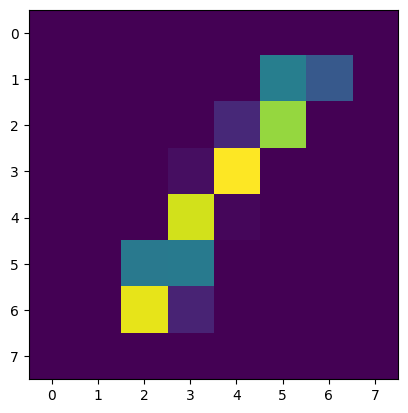

In [42]:
plt.imshow(statevector.reshape(8, 8))

Where we have reduced the depth by 72.85 percent without losing fidelity. This is how we can properly compete with exact encodings in terms of fidelity. The presented approach based on works prior to 2025 is state-of-the-art on general cases, excluding works such as [[6]], [[7]], and [[8]] which utilize mid-circuit measurements and focus on short-range entangled MPS which are reduced to a small, physically relevant space of states.

For our purposes, this is SOTA for general statevectors. Future improvements include using brickwall ansatz, implementing Iter Di Oall, and optimizing two qubit unitary synthesis. Additionally, works such as AQCTensor [[9]] which use more intensive variational optimization can further complement the methods presented here albeit with more classical computational cost.

[6]: https://arxiv.org/pdf/2307.01696
[7]: https://arxiv.org/pdf/2503.14645
[8]: https://arxiv.org/abs/2404.16083
[9]: https://arxiv.org/pdf/2503.09683

Let's run the algorithm on a set of randomly generated states as we increase the number of qubits, and plot the depth and fidelity as they increase. This way we can get a better understanding of how the algorithm performs.

In [30]:
from quick.synthesis.statepreparation import Isometry

sequential = Sequential(QiskitCircuit)
isometry = Isometry(QiskitCircuit)

def generate_random_state(num_qubits: int) -> NDArray[np.complex128]:
    data = np.random.rand(2**num_qubits) + 1j * np.random.rand(2**num_qubits)
    data /= np.linalg.norm(data)
    return data

def generate_plot(num_qubits: int) -> tuple[list[int], list[int], list[int]]:
    isometry_depths = []
    sequential_depths = []
    sequential_fidelities = []

    for qubit in tqdm(range(2, num_qubits+1)):
        state = generate_random_state(qubit)

        circuit = isometry.prepare_state(state)
        depth = circuit.get_depth()
        isometry_depths.append(depth)

        mps = MPS(statevector=state, bond_dimension=2**qubit)
        if qubit < 6:
            circuit = sequential.prepare_mps(mps, num_layers=5, num_sweeps=qubit*15)
        elif qubit < 10:
            circuit = sequential.prepare_mps(mps, num_layers=8, num_sweeps=qubit*15)
        elif qubit < 14:
            circuit = sequential.prepare_mps(mps, num_layers=15, num_sweeps=qubit*15)
        else:
            circuit = sequential.prepare_mps(mps, num_layers=20, num_sweeps=qubit*15)
        depth = circuit.get_depth()
        sequential_depths.append(depth)
        print(circuit.count_ops())

        sequential_fidelities.append(np.dot(circuit.get_statevector().conj().T, state))

    return isometry_depths, sequential_depths, sequential_fidelities

isometry_depths, sequential_depths, sequential_fidelities = generate_plot(12)

 18%|█▊        | 2/11 [00:00<00:00, 17.36it/s]

{'U3': 9, 'GlobalPhase': 10, 'CX': 3}
{'U3': 17, 'GlobalPhase': 19, 'CX': 6}
{'U3': 123, 'GlobalPhase': 134, 'CX': 44}
{'U3': 165, 'GlobalPhase': 184, 'CX': 60}


 45%|████▌     | 5/11 [00:07<00:09,  1.62s/it]

{'U3': 328, 'GlobalPhase': 366, 'CX': 120}


 55%|█████▍    | 6/11 [00:19<00:21,  4.25s/it]

{'U3': 392, 'GlobalPhase': 438, 'CX': 144}


 64%|██████▎   | 7/11 [00:35<00:28,  7.23s/it]

{'U3': 456, 'GlobalPhase': 510, 'CX': 168}


 73%|███████▎  | 8/11 [01:01<00:36, 12.33s/it]

{'U3': 520, 'GlobalPhase': 583, 'CX': 192}


 82%|████████▏ | 9/11 [04:50<02:25, 72.66s/it]

{'U3': 1095, 'GlobalPhase': 1227, 'CX': 405}


 91%|█████████ | 10/11 [17:59<04:36, 276.71s/it]

{'U3': 1215, 'GlobalPhase': 1362, 'CX': 450}


100%|██████████| 11/11 [33:00<00:00, 180.07s/it]

{'U3': 1335, 'GlobalPhase': 1496, 'CX': 495}


[0.9999999999999998, 0.9999999999999996, 1.0000000000000002, 0.9999999999999987, 0.9999999999999976, 0.9999999999998372, 0.9993833081918707, 0.9856561882831156, 0.990348166799249, 0.9625191328840889, 0.9318239807292739]
[7, 13, 65, 73, 115, 121, 127, 133, 223, 229, 235]
[3, 9, 23, 53, 115, 241, 495, 1005, 2027, 4073, 8167]


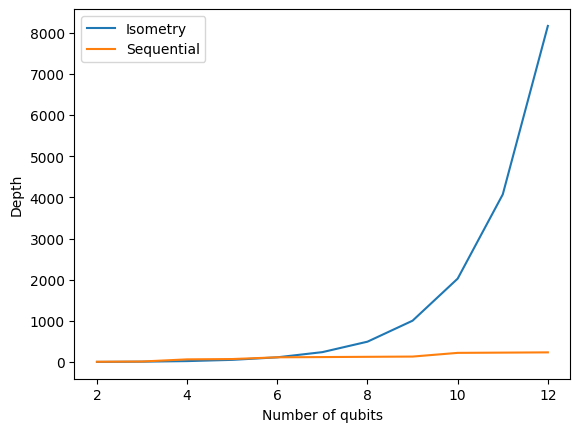

In [31]:
print([abs(x) for x in sequential_fidelities])
print(sequential_depths)
print(isometry_depths)

plt.plot(range(2, 13), isometry_depths, label="Isometry")
plt.plot(range(2, 13), sequential_depths, label="Sequential")

plt.xlabel("Number of qubits")
plt.ylabel("Depth")

plt.legend()
plt.show()

[1.0, 1.0, 1.0000000000000004, 0.9999999999999998, 0.9999999999999993, 0.9999997071294594, 0.9977914824258158, 0.9816392969307522, 0.9771892946417928, 0.9448254981312247, 0.9150761964523648]
[7, 13, 53, 73, 115, 121, 127, 133, 187, 193, 199]
[3, 9, 23, 53, 115, 241, 495, 1005, 2027, 4073, 8167]


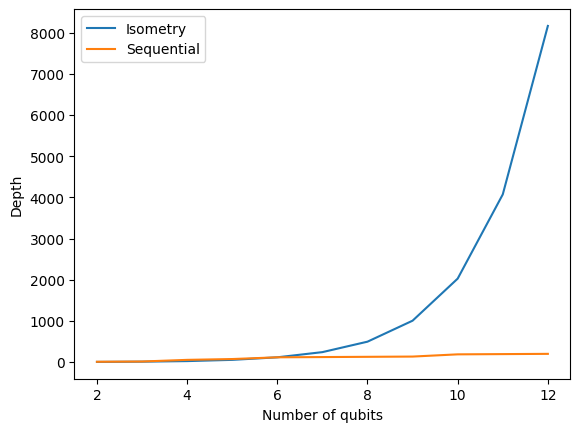

In [29]:
print([abs(x) for x in sequential_fidelities])
print(sequential_depths)
print(isometry_depths)

plt.plot(range(2, 13), isometry_depths, label="Isometry")
plt.plot(range(2, 13), sequential_depths, label="Sequential")

plt.xlabel("Number of qubits")
plt.ylabel("Depth")

plt.legend()
plt.show()

In [47]:
# Fit a linear model to half of the data
linear_fit = np.polyfit(range(2, 13), sequential_depths[:11], 1)

# Predict the depth of the remaining data
linear_values = np.polyval(linear_fit, range(2, 13))
linear_values

array([  3.27272727,  27.        ,  50.72727273,  74.45454545,
        98.18181818, 121.90909091, 145.63636364, 169.36363636,
       193.09090909, 216.81818182, 240.54545455])

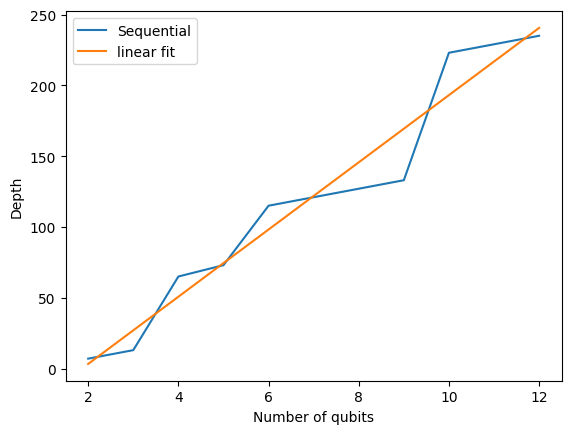

In [48]:
plt.plot(range(2, 13), sequential_depths, label="Sequential")
plt.plot(range(2, 13), linear_values, label="linear fit")
plt.xlabel("Number of qubits")
plt.ylabel("Depth")

plt.legend()
plt.show()

- Depth scaling: In the isometry approach, we see the depth approximately double as we add a qubit, which gives it its notorious exponential scaling of $O(2^N)$, whereas in Sequential encoding we linearly scale, giving it $O(N)$.
- Fidelity: As the number of qubits increases, we can see the approximation begins to slightly reduce. This is expected from vanilla Sequential as the algorithm does not scale significantly with increasing number of layers, thus why we have optimizations to improve the fidelity and indirectly depth scaling for a target fidelity.


So, as we see the Sequential approach indeed provides an exponential reduction in circuit depth scaling, however, we pay for this reduction with a slight hit to the fidelities. 'Tis the cost of approximation gentlefolk.

For those more curious, let's take the analysis further. Below, we can see the impact of the number of layers more closely.

First, let's compare the fidelity scaling of a randomly generated state as we increase the number of layers. We will do a few instances, but with varying bond dimension.

In [49]:
def generate_scaling(
        statevector: NDArray[np.complex128],
        bond_dimension: int,
        num_layers: int
    ) -> tuple[list[int], list[int]]:

    sequential_depths = []
    sequential_fidelities = []

    for i in range(1, num_layers+1):
        mps = MPS(statevector=statevector, bond_dimension=bond_dimension)
        circuit = sequential.prepare_mps(mps, num_layers=i)
        depth = circuit.get_depth()
        sequential_depths.append(depth)
        sequential_fidelities.append(np.dot(circuit.get_statevector().conj().T, statevector))

    return sequential_depths, sequential_fidelities

In [50]:
state = generate_random_state(12)
sequential_encoder = Sequential(QiskitCircuit)

In [52]:
print("Running with bond dimension 8.")
depths_1, fidelities_1 = generate_scaling(state, 8, 32)

print("Running with bond dimension 16.")
depths_2, fidelities_2 = generate_scaling(state, 16, 32)

print("Running with bond dimension 32.")
depths_3, fidelities_3 = generate_scaling(state, 32, 32)

print("Running with bond dimension 64.")
depths_4, fidelities_4 = generate_scaling(state, 64, 32)

print("Running with bond dimension 128.")
depths_5, fidelities_5 = generate_scaling(state, 128, 32)

Running with bond dimension 8.
Running with bond dimension 16.
Running with bond dimension 32.
Running with bond dimension 64.
Running with bond dimension 128.


/home/ace07/Documents/GitHub/QMPRS/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ace07/Documents/GitHub/QMPRS/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


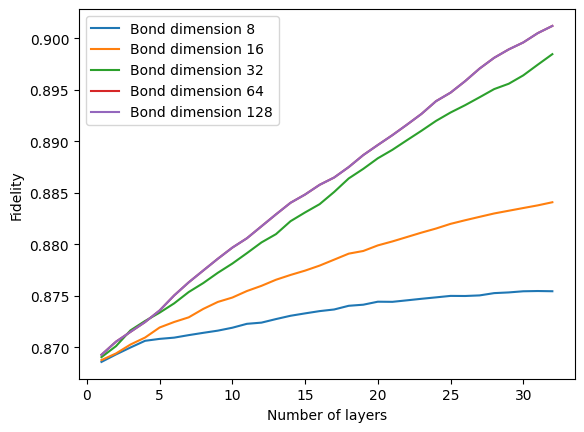

In [53]:
plt.plot(range(1, 33), fidelities_1, label="Bond dimension 8")
plt.plot(range(1, 33), fidelities_2, label="Bond dimension 16")
plt.plot(range(1, 33), fidelities_3, label="Bond dimension 32")
plt.plot(range(1, 33), fidelities_4, label="Bond dimension 64")
plt.plot(range(1, 33), fidelities_5, label="Bond dimension 128")

plt.xlabel("Number of layers")
plt.ylabel("Fidelity")

plt.legend()
plt.show()

We can see that different bond dimension can affect the max fidelity. Now let's compare the growth in two different states, one randomly generated, and one being the MNIST image we initially encoded.

In [54]:
layers = range(1, 100)
fidelities = []
depths = []

state = generate_random_state(8)
sequential_encoder = Sequential(QiskitCircuit)
mps = MPS(statevector=state, bond_dimension=8)

for layer in layers:
    circuit = sequential_encoder.prepare_mps(mps, num_layers=layer)
    statevector = circuit.get_statevector()
    fidelity = abs(np.dot(statevector.conj(), state))
    fidelities.append(fidelity)
    depths.append(circuit.get_depth())

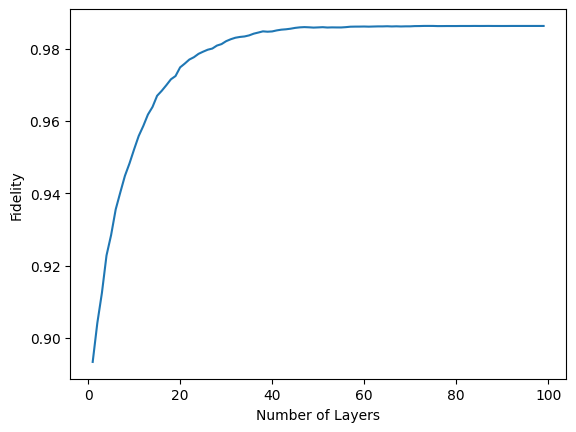

In [55]:
plt.plot(layers, fidelities)
plt.xlabel("Number of Layers")
plt.ylabel("Fidelity")
plt.show()

We can see the fidelity's growth slows and eventually stops after a certain number of layers. This is because given the approximation after a few layers the MPS cannot be disentangled further. Therefore the higher the bond dimension, the further we can push the max fidelity. Thus with a well-chosen bond dimension one can find the best number of layers given the point of plateau.

In [56]:
# Create a `quick.primitives.Ket` instance
state = Ket(test_image.flatten())

# Create a `qmprs.mps.MPS` instance
mps = MPS(statevector=state, bond_dimension=8)

In [57]:
layers = range(1, 100)
fidelities = []
depths = []

sequential_encoder = Sequential(QiskitCircuit)

for layer in layers:
    circuit = sequential_encoder.prepare_mps(mps, num_layers=layer)
    statevector = circuit.get_statevector()
    fidelity = abs(np.dot(statevector.conj(), state.data.flatten()))
    fidelities.append(fidelity)
    depths.append(circuit.get_depth())

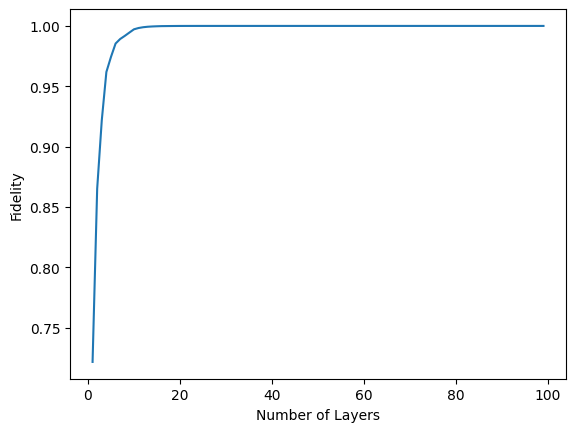

In [58]:
plt.plot(layers, fidelities)
plt.xlabel("Number of Layers")
plt.ylabel("Fidelity")
plt.show()

Here is an important matter to note. MPS was originally conceived to approximate *weakly* entangled states. Data such as images are of this category[[4]], and thus they are much easier to approximate, and reach target fidelity much much faster compared to randomly generated states. This is something that is expected and forms the pillar of why MPS is useful in the first place. With MPS representation we exploit the entanglement structure in a state, and thus data with weak entanglement will be much easier to encode and approximate.

[4]: https://arxiv.org/abs/2311.07666 

Lastly, let's perform an experiment where we just increase the bond dimension.

In [59]:
state = generate_random_state(8)
sequential_encoder = Sequential(QiskitCircuit)

depths = []
fidelities = []

for i in range(1, 10):
    mps = MPS(statevector=state, bond_dimension=2**i)
    circuit = sequential_encoder.prepare_mps(mps, num_layers=32)
    depths.append(circuit.get_depth())
    fidelities.append(np.dot(circuit.get_statevector().conj().T, state))

/home/ace07/Documents/GitHub/QMPRS/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ace07/Documents/GitHub/QMPRS/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


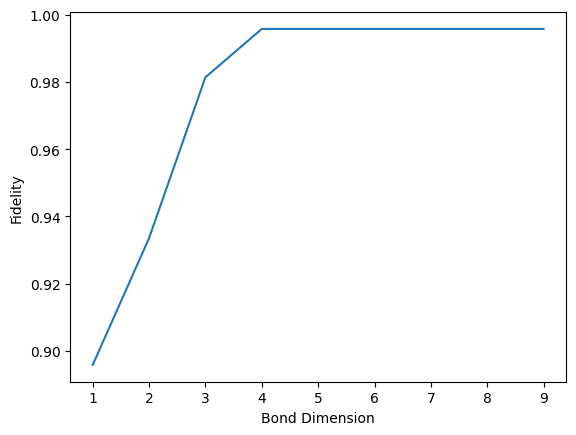

In [60]:
plt.plot(range(1, 10), fidelities)
plt.xlabel("Bond Dimension")
plt.ylabel("Fidelity")
plt.show()

We can see that the growth plateaus after a while. This means the state is adequately approximated through the MPS, and the bond dimension does not provide any considerable improvements to the approximation from this point forward.

### Final thoughts

MPS is a natural tool for quantum computing given how quantum circuits are essentially tensor networks. By utilizing such structures, we can address bottlenecks such as state preparation, unitary preparation, and by extention any arbitrary quantum computing use-case. Same as all things, they have their downsides, such as the need for higher bond dimension and number of layers to represent arbitrary states as MPS, as well as the classical computation runtime needed due to performing many tensor operations.

Our focus with `qmprs` is to provide a compiler with robust and stable performance for arbitrary states and operators, however, this is one challenge that is inherent to matrix product synthesis as a whole.

<p>© 2025 Qualition Computing, all rights reserved.</p>